### Fetures

#### CPU load 0 ~ 100
#### Network IO 0 ~ 100
#### Hourofday 0 ~ 100

In [6]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from mpl_toolkits.mplot3d import Axes3D

def retrieveHourOfDay(h, size=1):
    x = np.arange(size, dtype=int)
    return np.full_like(x, 100 * h/ 24, dtype=np.double)

def generateTimeRange(startHour, endHour, batch_size):
    hoursofday = np.array([])
    for hour in range(startHour, endHour + 1):
        hoursofday = np.append(hoursofday, retrieveHourOfDay(hour, batch_size))
    return hoursofday

def generateCPULoadOrNetwork(start, end, data_size):
    return np.reshape(np.random.uniform(start, end, data_size), (data_size, 1))

def train_normal(cpu, network):
    
    # idle data from 01:00 to 07:00
    cpu_load_1 = generateCPULoadOrNetwork(cpu, cpu + 10, 350)
    net_work_1 = generateCPULoadOrNetwork(network, network + 10, 350)
    hourofday_1 = generateTimeRange(1, 7, 50)
    
    # growing data from 07:00 to 10:00
    cpu_load_2 = generateCPULoadOrNetwork(cpu + 10, cpu + 20, 200)
    net_work_2 = generateCPULoadOrNetwork(network + 10, network + 20, 200)
    hourofday_2 = generateTimeRange(7, 10, 50)
    
    # busy data from 10:00 to 19:00
    cpu_load_3 = generateCPULoadOrNetwork(cpu + 20, cpu + 30, 500)
    net_work_3 = generateCPULoadOrNetwork(network + 20, network + 30, 500)
    hourofday_3 = generateTimeRange(10, 19, 50)
    
    # decrease data from 19:00 to 21:00
    cpu_load_4 = generateCPULoadOrNetwork(cpu + 10, cpu + 20, 150)
    net_work_4 = generateCPULoadOrNetwork(network + 10, network + 20, 150)
    hourofday_4 = generateTimeRange(19, 21, 50)
    
    # idle data from 21:00 to 24:00
    cpu_load_5 = generateCPULoadOrNetwork(cpu, cpu + 10, 200)
    net_work_5 = generateCPULoadOrNetwork(network, network + 10, 200)
    hourofday_5 = generateTimeRange(21, 24, 50)
    
    # concate busy, growing, decrease and idle data
    cpu_load = np.r_[cpu_load_1, cpu_load_2, cpu_load_3, cpu_load_4, cpu_load_5]
    net_work = np.r_[net_work_1, net_work_2, net_work_3, net_work_4, net_work_5]
    hourofday = np.reshape(np.r_[hourofday_1, hourofday_2, hourofday_3, hourofday_4, hourofday_5], (1400, 1))
    # stack data as feature matrix
    features = np.hstack((cpu_load, net_work, hourofday))
    # Train model
    rng = np.random.RandomState(42)
    clf_iso_forest = IsolationForest(n_estimators=100, max_samples=100, contamination=0.2, max_features=3, random_state=rng)
    clf_iso_forest.fit(features)
    return features, clf_iso_forest


def train_with_business_grow(cpu, network):
    features = None
    clf_iso_forest = None
    for i in range(1, 17):
        features, clf_iso_forest = train_normal(cpu + i, network + i)
        plot_data(features, idx=i)
    return features, clf_iso_forest

def generateTestFeatures():
    test_features = []
    # normal data at 3:00
    test_features.append(np.array([15, 15, retrieveHourOfDay(3)]))
    # anormaly data at 03:00
    test_features.append(np.array([30, 30, retrieveHourOfDay(3)]))
    
    # normal data at 8:00
    test_features.append(np.array([25, 25, retrieveHourOfDay(8)]))
    # anormaly data at 8:00
    test_features.append(np.array([40, 40, retrieveHourOfDay(8)]))
    
    # normal data at 12:00
    test_features.append(np.array([35, 35, retrieveHourOfDay(12)]))
    # anormaly data at 12:00
    test_features.append(np.array([50, 50, retrieveHourOfDay(12)]))
    
    # normal data at 20:00
    test_features.append(np.array([25, 25, retrieveHourOfDay(20)]))
    # anormaly data at 20:00
    test_features.append(np.array([40, 40, retrieveHourOfDay(20)]))
    
    # normal data at 23:00
    test_features.append(np.array([15, 15, retrieveHourOfDay(23)]))
    # anormaly data at 23:00
    test_features.append(np.array([30, 30, retrieveHourOfDay(23)]))
    
    test_features = np.reshape(test_features, (10, 3))
    
    return test_features


def generateSpecifyTestFeatures(cpu, network, time):
    test_features = []
    test_features.append(np.array([cpu, network, retrieveHourOfDay(time)]))
    return np.reshape(test_features, (1, 3))

def predict(features, model):
    prediction = model.predict(features)
    return prediction


def retrieveColor(pred):
    if pred == -1:
        return 'r'
    else:
        return 'g'

def plot_data(normal_features, test_features=None, predictions=None, angle=None, idx=None):
    # create figure
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('TIME')
    ax.set_ylabel('CPU')
    ax.set_zlabel('NETWORK IO')
    # plot train data
    ax.scatter(normal_features[:,-1:], normal_features[:,:1], normal_features[:,1:2], c='skyblue', marker='^')
    # plot test data according prediction
    if predictions is not None:
        for idx, pred in enumerate(predictions):
            curr_time = test_features[idx][2]
            curr_cpu = test_features[idx][0]
            curr_network = test_features[idx][1]
            ax.text(curr_time, curr_cpu + 1, curr_network + 1, (curr_cpu, curr_network), color=retrieveColor(pred))
            ax.scatter(curr_time, curr_cpu, curr_network, c=retrieveColor(pred), marker='o')
    if angle is not None:
        ax.view_init(30, 140 + angle)
        filename = 'plot' + str(int(angle/10 - 4)) + '.jpg'
    else:
        filename = 'plot' + str(idx) + '.jpg'
    plt.savefig(filename)
    
def plot_data_in_different_angle(features, test_features, prediction):
    for angle in range(5, 21):
        r = angle * 10
        plot_data(features, test_features, prediction, r)

In [4]:
def storeTrainFeatures(train_features):
    with h5py.File('train.h5') as h:
        h.create_dataset("train", data=train_features)

def loadTrainFeatures():
    train_features = None
    with h5py.File('train.h5', 'r') as h:
        train_features = np.array(h['train'])
    return train_features

In [2]:
# train model
features, model = train_normal(cpu=10, network=10)

In [7]:
storeTrainFeatures(features)

In [8]:
features = loadTrainFeatures()

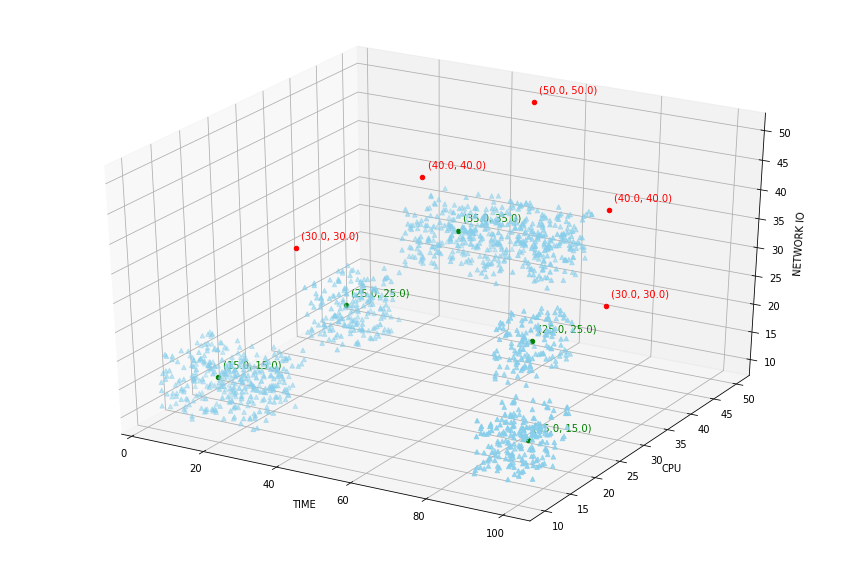

In [9]:
# test model
test_features = generateTestFeatures()

prediction = predict(test_features, model)

plot_data(features, test_features, prediction)

In [3]:
#train_with_business_grow(10, 10)